# IMDB-WIKI
##  Multi-task age and gender classification

On the original paper [DEX: Deep EXpectation of apparent age from a single image](https://www.vision.ee.ethz.ch/en/publications/papers/proceedings/eth_biwi_01229.pdf) the authors were able to display remarkable results in classifying the age of an individual based on a given image alone. 

Let see how accuracy (bad I guess), with limited resources, we can get with self-construct architecture. And not only age, we also classifying gender by using multi-task training technique.

In [1]:
import os
from six.moves import cPickle as pickle
import numpy as np
import scipy.io as sio
import scipy.misc as spm
from scipy import ndimage
import datetime
import matplotlib.image as plt
from IPython.display import Image, display
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from collections import Counter
# from skimage.transform import resize

IMG_DIR = os.path.expanduser("~")+'/coding/cnn/datasets/imdb_crop'
MAT_FILE = os.path.expanduser("~")+'/coding/cnn/datasets/imdb_crop/imdb.mat'

First, the labels, which was not easily obtained. The meta data is stored separately and in a .mat file. (Yes, matlab)!

The age parameter, requires us to calculate by taking the ```photo_taken``` and subtracting the ```dob```, the date of birth. Sounds easy? No ... as the dob is stored as a Matlab serial number.

Luckily we can use the ```scipy.io.loadmat``` to load the ```.mat``` file to python accessible (kind of) format. We can access the ```dob``` by some proper indexing, and convert the Matlab serial number to a usable format by using ```datetime.date.fromordinal( serial_number ).year```.

In [2]:
def reformat_date(mat_date):
    dt = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return dt

In [3]:
def create_path(path):
    return os.path.join(IMG_DIR, path[0])

In [4]:
mat_struct = sio.loadmat(MAT_FILE)
data_set = [data[0] for data in mat_struct['imdb'][0, 0]]

keys = ['dob',
    'photo_taken',
    'full_path',
    'gender',
    'name',
    'face_location',
    'face_score',
    'second_face_score',
    'celeb_names',
    'celeb_id'
]

imdb_dict = dict(zip(keys, np.asarray(data_set)))
imdb_dict['dob'] = [reformat_date(dob) for dob in imdb_dict['dob']]
imdb_dict['full_path'] = [create_path(path) for path in imdb_dict['full_path']]

# Add 'age' key to the dictionary
imdb_dict['age'] = imdb_dict['photo_taken'] - imdb_dict['dob']

print("Dictionary created...")

Dictionary created...


The IMDB dataset has total 460,723 face images from 20,284 celebrities. 

We will ignore:
* images with more than one face
* gender is NaN
* invalid age.

As we are using only a subset of the data, and also using a self-constructed model that has a much smaller capacity, thus we need to take steps to adjust accordingly.

~~The original paper uses 101 age classes, which was appropriate for the their data set size and learning architecture. As we are only using a small subset of the data and a very simple model, the number of classes was set to 4:~~
* Young    (age < 30yrs)
* Middle   (30 <= age <45)
* Old      (45 <= age < 60)
* Very Old (60 <= age)

Another approach, 101 classes, age label from 0..100

In [ ]:
for _ in range(5):
    np.random.shuffle(X_age)
    np.random.shuffle(X_gender)

In [37]:
raw_path = imdb_dict['full_path']
raw_age = imdb_dict['age']
raw_gender = imdb_dict['gender']
raw_sface = imdb_dict['second_face_score']

age = []
gender = []
imgs = []
current_age = np.zeros(101)
for i, sface in enumerate(raw_sface):
    if np.isnan(sface) and raw_age[i] >= 0 and raw_age[i] <= 100 and not np.isnan(raw_gender[i]):
        age_tmp = 0;
        if current_age[raw_age[i]] >= 5000:
            continue
        age.append(raw_age[i])
        gender.append(raw_gender[i])
        imgs.append(raw_path[i])
        current_age[raw_age[i]] += 1

Age size: 194872


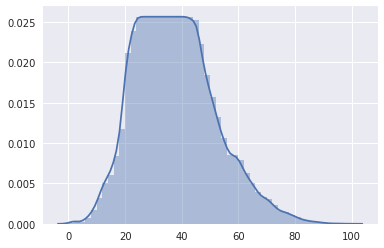

In [38]:
sns.distplot(age);
print("Age size: " + str(len(age)))

In [39]:
counter = Counter(age)
print(counter)

Counter({29: 5000, 31: 5000, 39: 5000, 42: 5000, 40: 5000, 38: 5000, 41: 5000, 43: 5000, 35: 5000, 34: 5000, 32: 5000, 45: 5000, 33: 5000, 36: 5000, 27: 5000, 30: 5000, 37: 5000, 26: 5000, 23: 5000, 28: 5000, 25: 5000, 24: 5000, 44: 4824, 46: 4794, 21: 4341, 22: 4295, 20: 3896, 47: 3887, 48: 3746, 49: 3444, 50: 3128, 51: 2984, 19: 2652, 52: 2626, 53: 2537, 55: 2155, 54: 1984, 18: 1905, 17: 1754, 56: 1715, 58: 1706, 60: 1644, 59: 1618, 57: 1586, 16: 1511, 61: 1431, 63: 1242, 62: 1211, 15: 1211, 14: 1161, 13: 1098, 65: 1019, 64: 952, 12: 886, 66: 868, 11: 779, 68: 699, 70: 694, 67: 684, 69: 572, 72: 518, 71: 485, 10: 447, 73: 381, 9: 379, 74: 337, 76: 293, 77: 288, 75: 288, 8: 272, 79: 220, 78: 214, 80: 178, 7: 144, 81: 140, 6: 124, 82: 120, 2: 116, 84: 93, 83: 79, 5: 67, 85: 65, 87: 58, 88: 50, 86: 47, 3: 37, 90: 36, 0: 31, 4: 24, 1: 20, 89: 18, 91: 18, 94: 10, 96: 10, 92: 8, 93: 7, 100: 3, 95: 3, 97: 2, 99: 2, 98: 1})


In [40]:
pickle_file = 'imdb-gender-age101.pkl'

try:
    f = open(os.getcwd()+"/pkl_folder/"+pickle_file, 'wb')
    save = {
    'age': age,
    'gender': gender,
    'imgs': imgs
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [9]:
raw_path = imdb_dict['full_path']
raw_age = imdb_dict['age']
raw_gender = imdb_dict['gender']
raw_name = imdb_dict['name']
raw_face_location = imdb_dict['face_location']
raw_face_score = imdb_dict['face_score']
raw_second_face_score = imdb_dict['second_face_score']
raw_celeb_names = imdb_dict['celeb_names']
raw_celeb_id = imdb_dict['celeb_id']

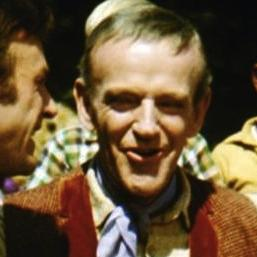

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/01/nm0000001_rm124825600_1899-5-10_1968.jpg
Age: 69
Gender: 1.0
Name: ['Fred Astaire']
Face location: [[1072.926  161.838 1214.784  303.696]]
Face score: 1.4596929136202572
Second face score: 1.1189733571573068
Celeb id: 6488



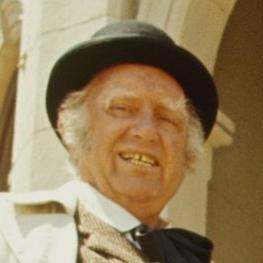

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/01/nm0000001_rm3343756032_1899-5-10_1970.jpg
Age: 71
Gender: 1.0
Name: ['Fred Astaire']
Face location: [[477.184 100.352 622.592 245.76 ]]
Face score: 2.5431975987694435
Second face score: 1.852007728341101
Celeb id: 6488



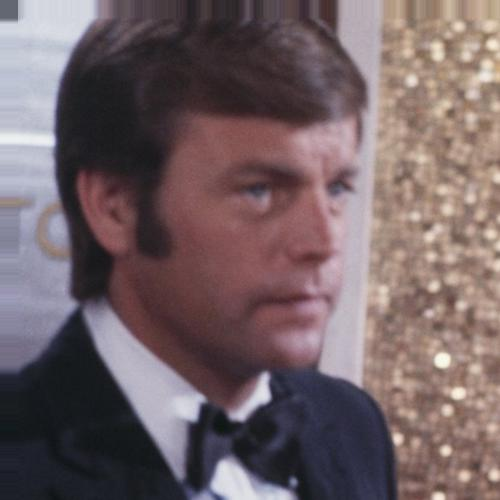

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/01/nm0000001_rm577153792_1899-5-10_1968.jpg
Age: 69
Gender: 1.0
Name: ['Fred Astaire']
Face location: [[114.96964309 114.96964309 451.68657236 451.68657236]]
Face score: 3.455579487909806
Second face score: 2.9856602160994425
Celeb id: 6488



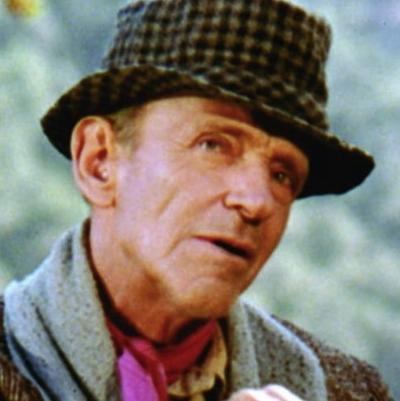

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/01/nm0000001_rm946909184_1899-5-10_1968.jpg
Age: 69
Gender: 1.0
Name: ['Fred Astaire']
Face location: [[622.88550564 424.21750384 844.33900767 645.67100587]]
Face score: 1.872117169344902
Second face score: nan
Celeb id: 6488



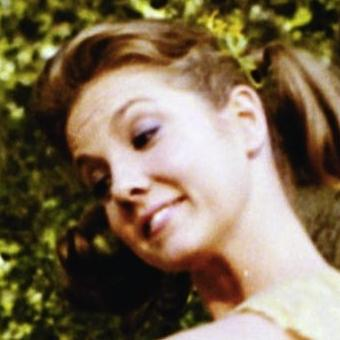

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/01/nm0000001_rm980463616_1899-5-10_1968.jpg
Age: 69
Gender: 1.0
Name: ['Fred Astaire']
Face location: [[1013.85900236  233.88204221 1201.5861278   421.60916765]]
Face score: 1.1587657871914132
Second face score: nan
Celeb id: 6488



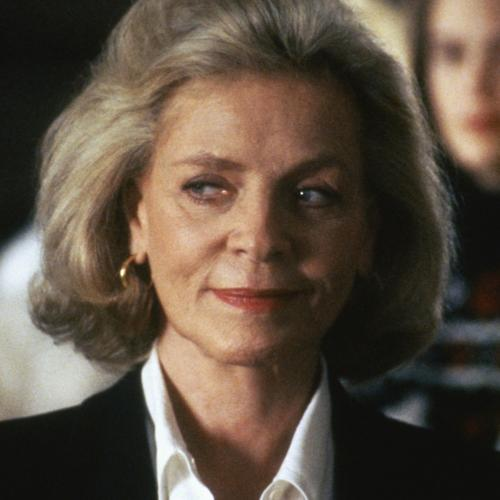

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm1075631616_1924-9-16_1991.jpg
Age: 67
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 686.67682059  458.46721373 1198.10043604  969.89082917]]
Face score: 3.4905630909496344
Second face score: 1.3453352771625287
Celeb id: 11516



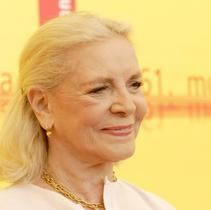

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm1346607872_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 78.23569407  52.33512938 194.25423516 168.35367048]]
Face score: 3.4791889134154426
Second face score: nan
Celeb id: 11516



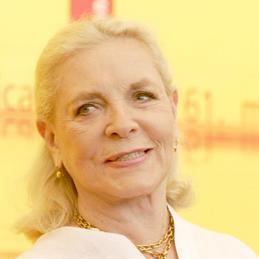

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm1363385088_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 64.30867104  64.30867104 207.26768087 207.26768087]]
Face score: 3.87017062712482
Second face score: nan
Celeb id: 11516



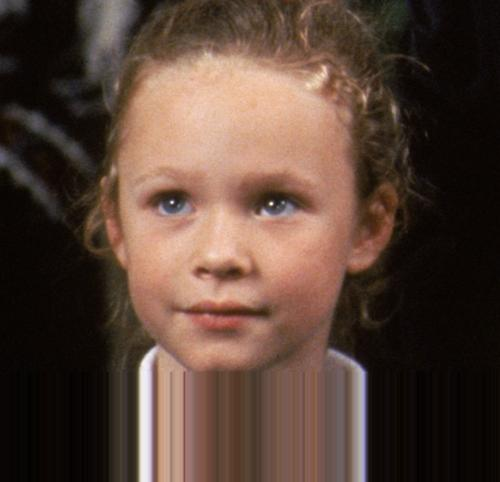

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm1411175936_1924-9-16_1991.jpg
Age: 67
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 212.76723692 1055.64418461  526.79809231 1357.824     ]]
Face score: 3.786498646396679
Second face score: 3.6297041401689754
Celeb id: 11516



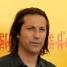

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm1447271168_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[242.176  49.664 278.528  86.016]]
Face score: 3.472943641929206
Second face score: 2.9451325883872235
Celeb id: 11516



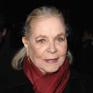

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm1624085760_1924-9-16_2008.jpg
Age: 84
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[108.03894851  28.82624961 158.4253978   79.2126989 ]]
Face score: 3.862810681579513
Second face score: 1.5253068067046478
Celeb id: 11516



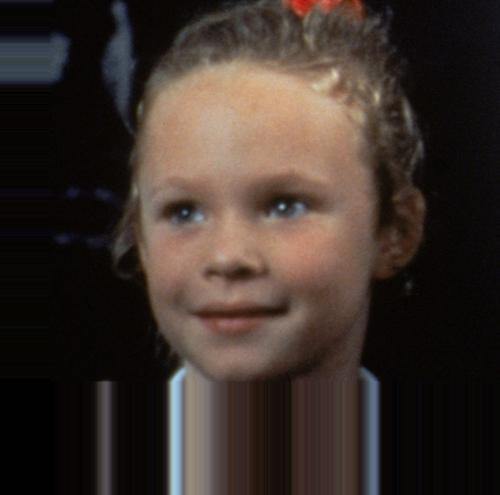

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm1646056960_1924-9-16_1991.jpg
Age: 67
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[  72.28774564 1055.64418461  386.31860102 1366.016     ]]
Face score: 3.767166077822234
Second face score: 3.4634604907317743
Celeb id: 11516



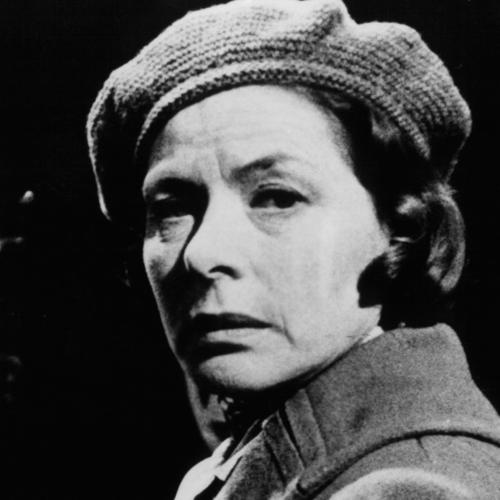

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm221957120_1924-9-16_1974.jpg
Age: 50
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[3173.14469259  401.04083657 4059.15207489 1287.04821887]]
Face score: 4.0964305784174595
Second face score: nan
Celeb id: 11516



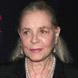

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2287049216_1924-9-16_2007.jpg
Age: 83
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[138.80620248  33.92673853 181.15543773  76.27597378]]
Face score: 3.482030102193067
Second face score: nan
Celeb id: 11516



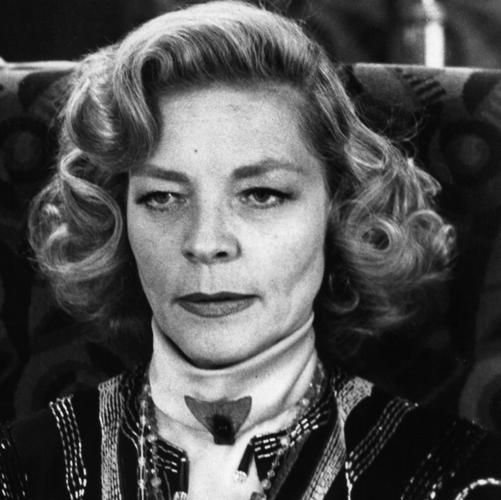

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm238734336_1924-9-16_1974.jpg
Age: 50
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[2135.21778394  765.85377998 3499.48578791 2130.12178394]]
Face score: 4.86542134035104
Second face score: nan
Celeb id: 11516



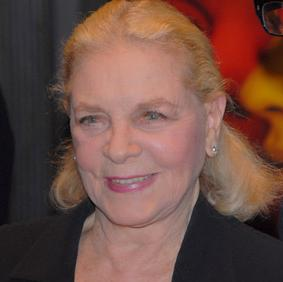

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2585828096_1924-9-16_2006.jpg
Age: 82
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 70.08922574  87.46603217 225.89848365 243.27529008]]
Face score: 5.414545418118097
Second face score: nan
Celeb id: 11516



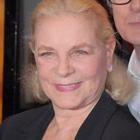

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2602605312_1924-9-16_2006.jpg
Age: 82
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 52.186 121.05  129.12  197.984]]
Face score: 4.349961336330576
Second face score: 3.2055228809775476
Celeb id: 11516



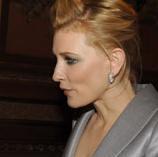

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2619382528_1924-9-16_2006.jpg
Age: 82
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[213.212  58.588 299.584 144.96 ]]
Face score: 4.361549044046394
Second face score: 1.494864797383042
Celeb id: 11516



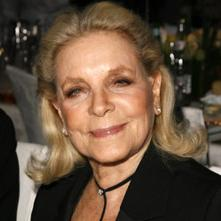

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2769394176_1924-9-16_2006.jpg
Age: 82
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[109.42467459  82.24100594 231.0611835  203.87751485]]
Face score: 4.360469497529326
Second face score: nan
Celeb id: 11516



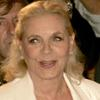

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2780403712_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[117.05057012  74.12636008 171.69684018 128.77263014]]
Face score: 3.5592090092501407
Second face score: nan
Celeb id: 11516



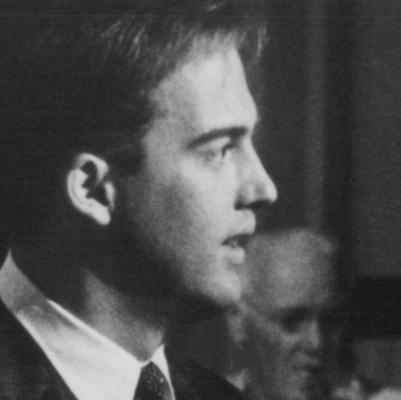

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2805435904_1924-9-16_1988.jpg
Age: 64
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[548.38500497 200.71600181 769.838507   422.16950384]]
Face score: 3.410720352171066
Second face score: 1.1966955393724619
Celeb id: 11516



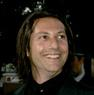

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2813958144_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[294.49013827  52.41849499 345.81663326 103.74498998]]
Face score: 4.344886669300918
Second face score: 3.783331115093286
Celeb id: 11516



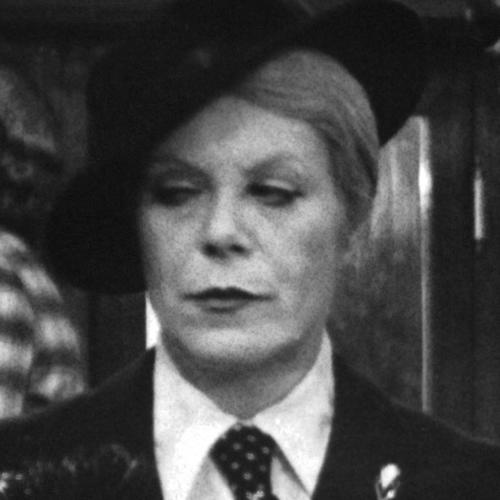

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm289065984_1924-9-16_1974.jpg
Age: 50
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 991.49939553  744.87654664 1430.41252351 1183.78967463]]
Face score: 4.635293675950249
Second face score: 3.9119280820863214
Celeb id: 11516



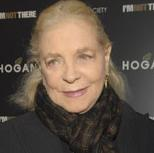

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm2983566080_1924-9-16_2007.jpg
Age: 83
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 85.53605744  47.74847636 170.04411489 132.2565338 ]]
Face score: 4.12685501353463
Second face score: nan
Celeb id: 11516



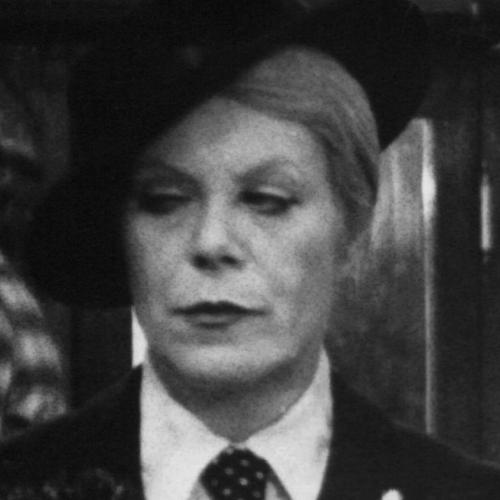

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm305843200_1924-9-16_1974.jpg
Age: 50
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[1020.12114152  743.27564838 1430.36838123 1153.52288809]]
Face score: 4.521520133398809
Second face score: 3.694407219378071
Celeb id: 11516



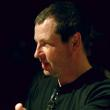

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm3224279040_1924-9-16_2005.jpg
Age: 81
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[317.3146448   88.26268899 377.26204487 148.21008906]]
Face score: 1.6660390625776365
Second face score: 0.8994610049743585
Celeb id: 11516



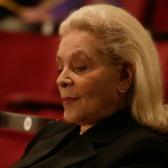

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm3453524224_1924-9-16_2007.jpg
Age: 83
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[197.03   72.998 289.408 165.376]]
Face score: 2.7783048288371797
Second face score: nan
Celeb id: 11516



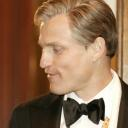

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm3487078656_1924-9-16_2007.jpg
Age: 83
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[274.80881255  63.31178573 344.66182149 133.16479467]]
Face score: 3.7398488125203393
Second face score: 3.190146010159886
Celeb id: 11516



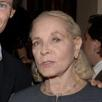

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm350394368_1924-9-16_2005.jpg
Age: 81
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[163.62184139  88.37822229 219.46055572 144.21693662]]
Face score: 3.4618366138397696
Second face score: 2.912146755664395
Celeb id: 11516



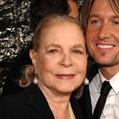

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm3537671424_1924-9-16_2008.jpg
Age: 84
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 80.61559618  58.78225177 145.55562943 123.72228501]]
Face score: 4.220182934106967
Second face score: 3.5445020654454304
Celeb id: 11516



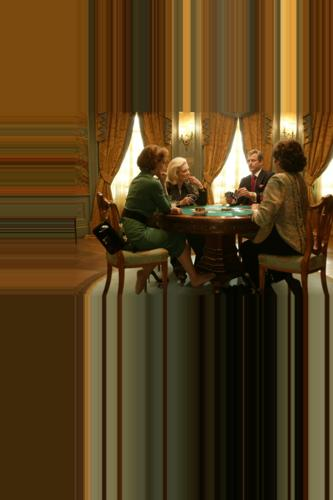

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm3587741952_1924-9-16_2007.jpg
Age: 83
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[  1   1 323 485]]
Face score: -inf
Second face score: nan
Celeb id: 11516



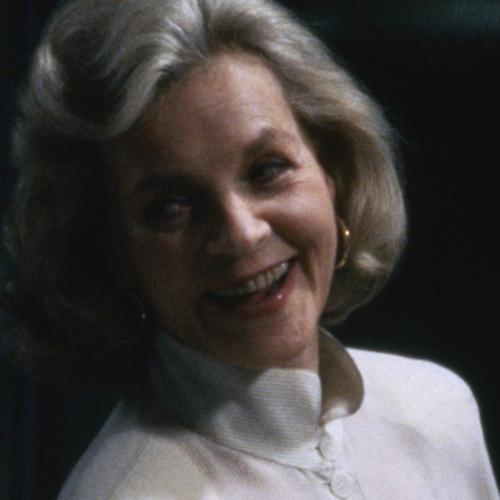

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm370988544_1924-9-16_1991.jpg
Age: 67
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[641.93731084 152.61019079 978.65424011 489.32712006]]
Face score: 1.0249593364837861
Second face score: nan
Celeb id: 11516



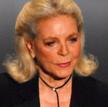

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm3730086656_1924-9-16_2006.jpg
Age: 82
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[152.02730197  46.67404842 210.70650709 105.35325354]]
Face score: 2.682337458731973
Second face score: nan
Celeb id: 11516



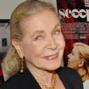

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm3954154240_1924-9-16_2006.jpg
Age: 82
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[120.16014205  33.17240238 168.53874561  81.55100594]]
Face score: 2.2782440129817445
Second face score: nan
Celeb id: 11516



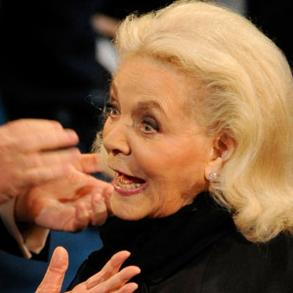

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm4111175424_1924-9-16_2010.jpg
Age: 86
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[109.13807259 109.13807259 270.85018147 270.85018147]]
Face score: 3.01481131341127
Second face score: nan
Celeb id: 11516



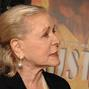

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm4175205632_1924-9-16_2008.jpg
Age: 84
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[121.46623055  66.50794393 170.3706885  115.41240188]]
Face score: 2.364435191384157
Second face score: 2.067178556415062
Celeb id: 11516



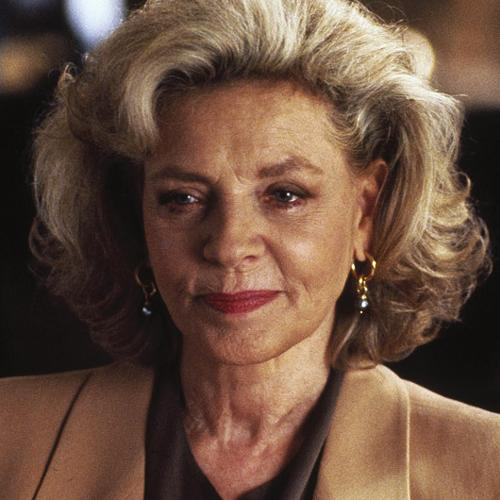

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm4213815808_1924-9-16_1990.jpg
Age: 66
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[328.383 197.439 621.984 491.04 ]]
Face score: 3.801101947562782
Second face score: nan
Celeb id: 11516



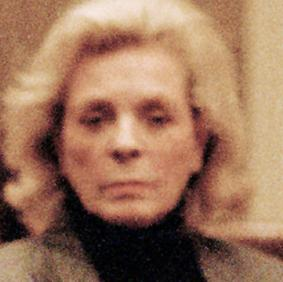

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm4258380288_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[1564.88234051  423.48647384 1720.8737682   579.47790154]]
Face score: 4.508299659148569
Second face score: 3.739836293581647
Celeb id: 11516



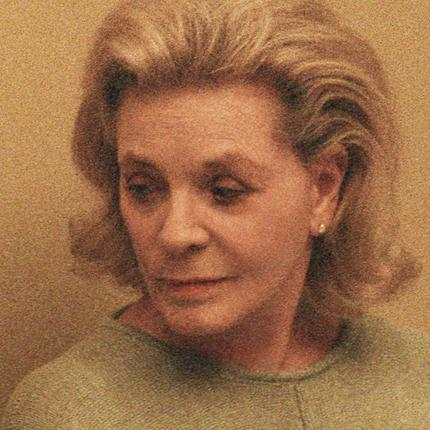

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm4291934720_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[1199.76289357  294.82275176 1437.25787229  532.31773048]]
Face score: 4.03764897393072
Second face score: 1.9674323857206453
Celeb id: 11516



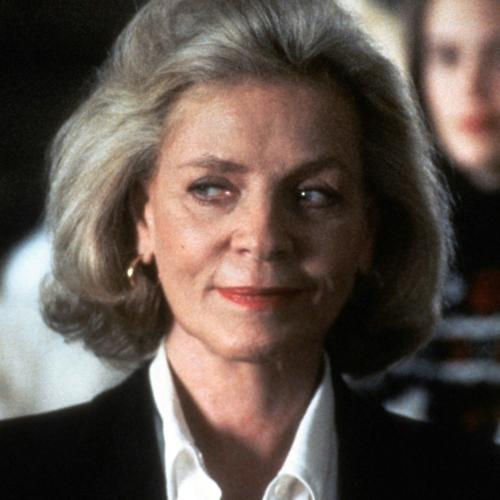

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm454874624_1924-9-16_1991.jpg
Age: 67
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 674.66775147  491.22600107 1222.94500267 1039.50325227]]
Face score: 3.6613924628083367
Second face score: 1.3952884609600202
Celeb id: 11516



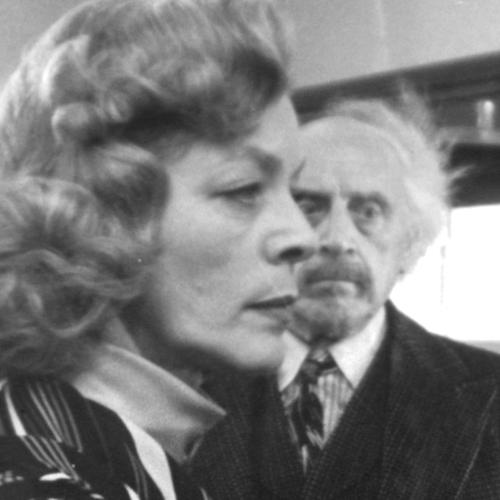

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm473615360_1924-9-16_1974.jpg
Age: 50
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[1115.06157357  560.04728679 1942.55000376 1387.53571697]]
Face score: 2.3070352377186185
Second face score: 2.085427703933935
Celeb id: 11516



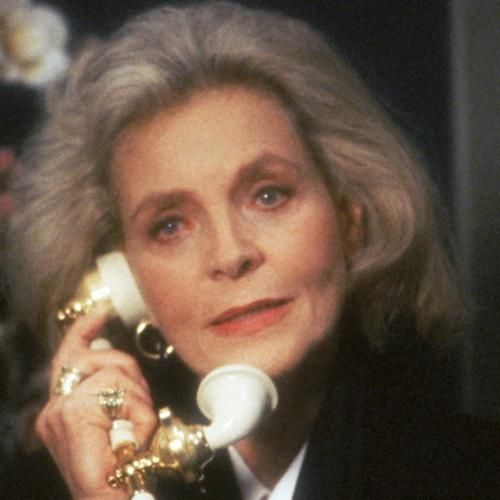

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm505206272_1924-9-16_1991.jpg
Age: 67
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 836.18510021  280.09370007 1251.20565032  695.11425018]]
Face score: 3.4542888874117925
Second face score: nan
Celeb id: 11516



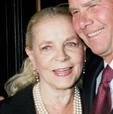

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm634689536_1924-9-16_2004.jpg
Age: 80
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 69.93284474 104.63226712 131.85780501 166.55722739]]
Face score: 3.2685460289578967
Second face score: 1.22344477780241
Celeb id: 11516



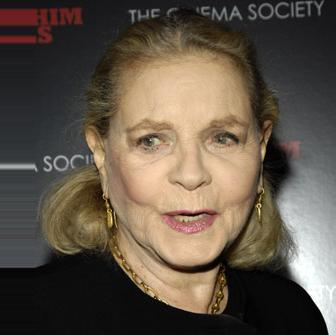

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm800626688_1924-9-16_2006.jpg
Age: 82
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 41.89528796  83.18857593 227.11308381 268.40637177]]
Face score: 5.272468247239644
Second face score: nan
Celeb id: 11516



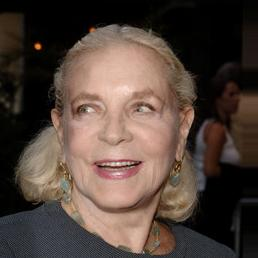

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm81958912_1924-9-16_2005.jpg
Age: 81
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 79.65119768  79.65119768 221.53935351 221.53935351]]
Face score: 4.723313369576708
Second face score: nan
Celeb id: 11516



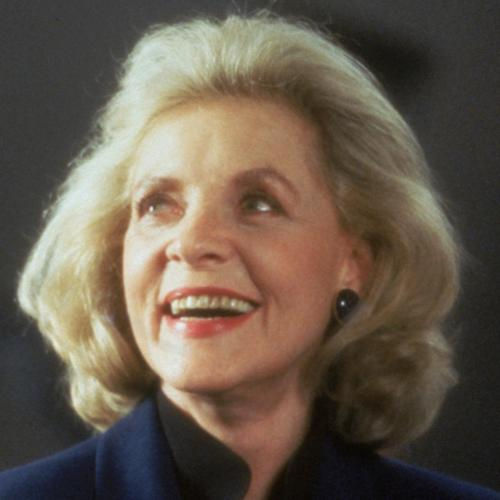

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/02/nm0000002_rm991745536_1924-9-16_1991.jpg
Age: 67
Gender: 0.0
Name: ['Lauren Bacall']
Face location: [[ 800.52459571  427.90218438 1277.56255314  904.94014181]]
Face score: 3.3516153597847174
Second face score: nan
Celeb id: 11516



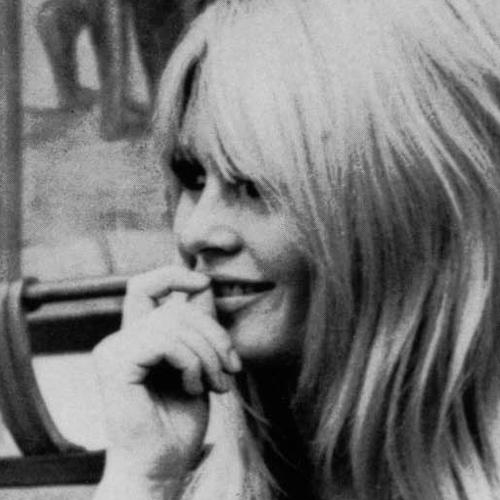

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm1514206208_1934-9-28_1966.jpg
Age: 32
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[1172.954  381.754 1455.808  664.608]]
Face score: 1.3310627398838877
Second face score: 1.1813295418220182
Celeb id: 2585



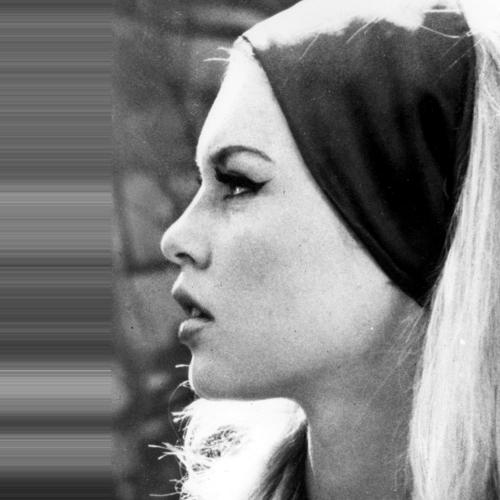

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm1883436032_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[   4.054  652.694 1167.552 1816.192]]
Face score: 3.056357723274137
Second face score: nan
Celeb id: 2585



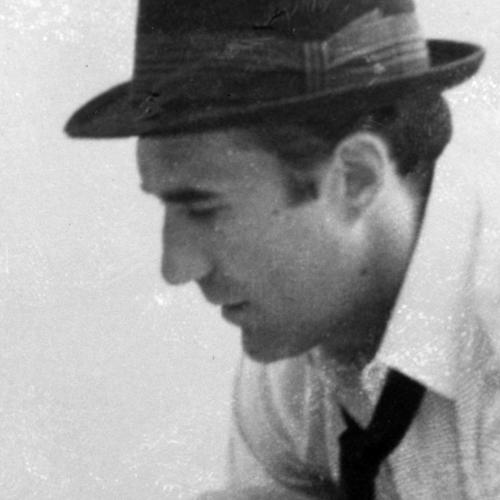

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm1900213248_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[3826.98998468  474.83122619 4424.84956121 1072.69080272]]
Face score: 1.8853980326107571
Second face score: nan
Celeb id: 2585



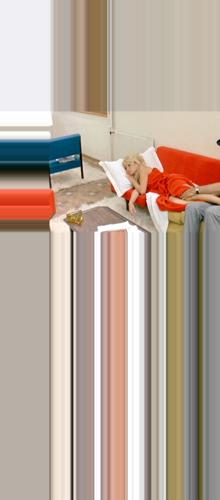

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2017653760_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[   1    1 2126 4842]]
Face score: -inf
Second face score: nan
Celeb id: 2585



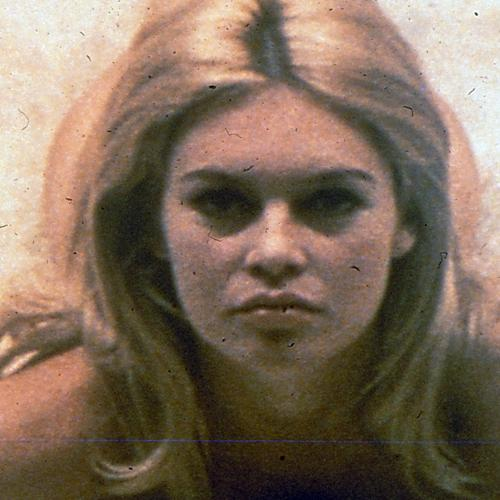

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2034430976_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[1045.25050069  350.00950023 1564.29225103  869.05125057]]
Face score: 3.776049153912105
Second face score: nan
Celeb id: 2585



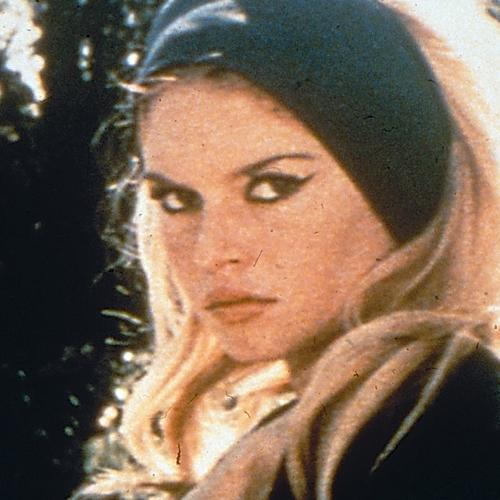

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2051208192_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[1017.40429911  590.01764685 1495.8532829  1068.46663064]]
Face score: 1.9945424575468278
Second face score: nan
Celeb id: 2585



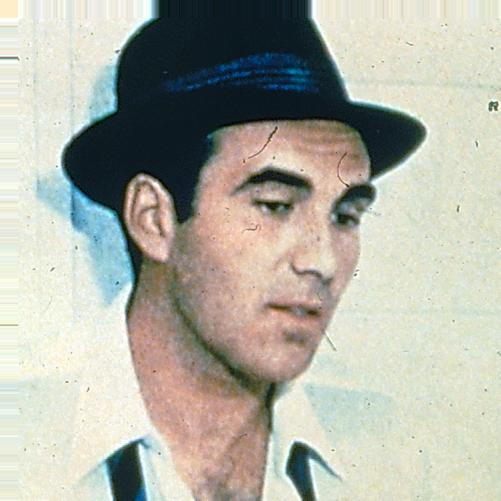

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2067985408_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[142.60527326 142.60527326 560.92909303 560.92909303]]
Face score: 2.7234192060117577
Second face score: nan
Celeb id: 2585



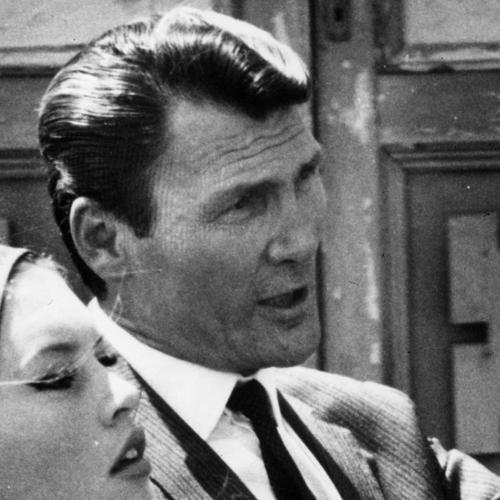

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2084762624_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[1382.52740535  980.41257879 1895.68418236 1493.5693558 ]]
Face score: 1.6645078911169486
Second face score: 1.514502321516685
Celeb id: 2585



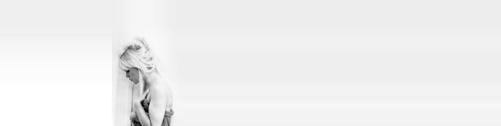

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2135094272_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[   1    1 5280 1331]]
Face score: -inf
Second face score: nan
Celeb id: 2585



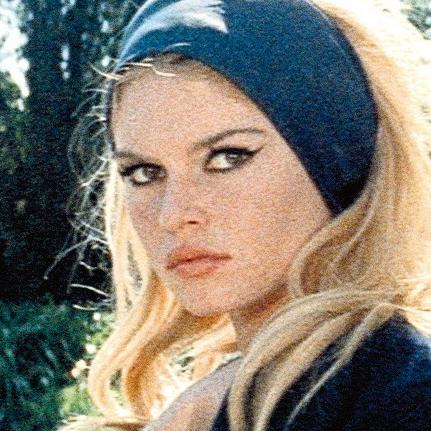

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2148710400_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[ 963.67440471  295.78801255 1202.19550589  534.30911373]]
Face score: 2.3413360843079296
Second face score: nan
Celeb id: 2585



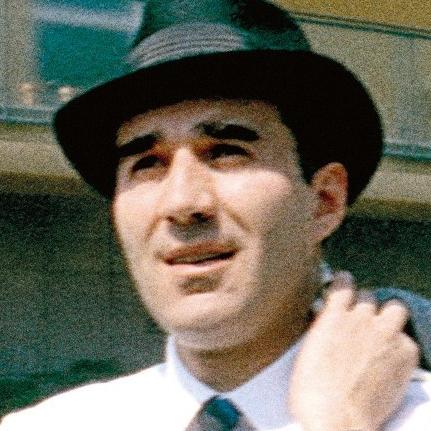

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm2165487616_1934-9-28_1963.jpg
Age: 29
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[1337.69078432  215.64164549 1576.2118855   454.16274667]]
Face score: 3.3879776742421788
Second face score: 1.889304159690581
Celeb id: 2585



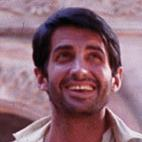

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3244276480_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[351.8787607  158.90809231 429.79830685 236.82763847]]
Face score: 3.700273671649512
Second face score: 3.573236172174119
Celeb id: 2585



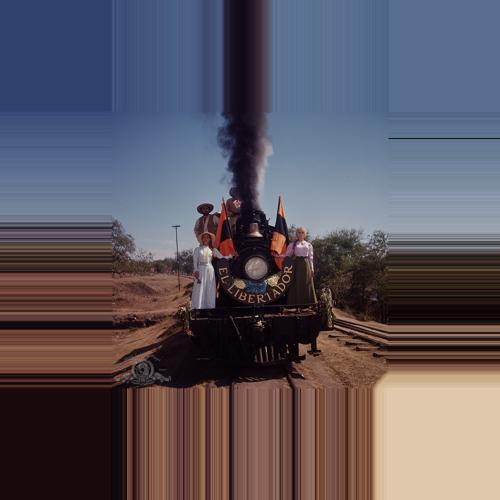

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3261053696_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[   1    1 1023 1023]]
Face score: -inf
Second face score: nan
Celeb id: 2585



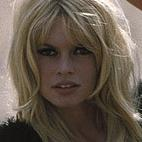

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3277830912_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[193.99366838 351.8787607  271.91321454 429.79830685]]
Face score: 4.10249306100235
Second face score: 3.908716928264441
Celeb id: 2585



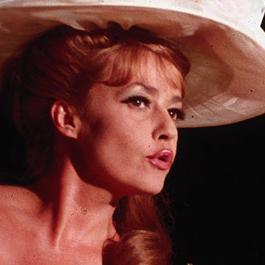

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3294608128_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[312.015 164.703 458.304 310.992]]
Face score: 2.9969154970029512
Second face score: 1.7038645903560694
Celeb id: 2585



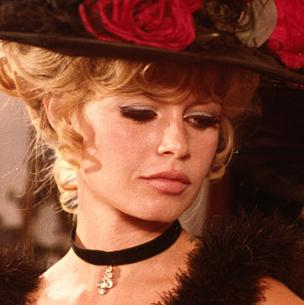

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3311385344_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[245.44763077 207.84384142 413.64168284 376.03789349]]
Face score: 3.810322011865103
Second face score: 2.0752559681993974
Celeb id: 2585



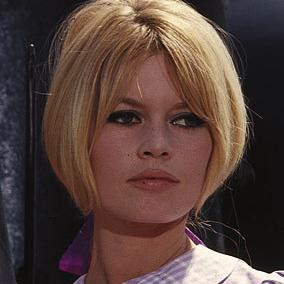

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3328162560_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[264.16482052 474.67827694 421.02691284 631.54036925]]
Face score: 4.177976564727137
Second face score: 1.6782583697822238
Celeb id: 2585



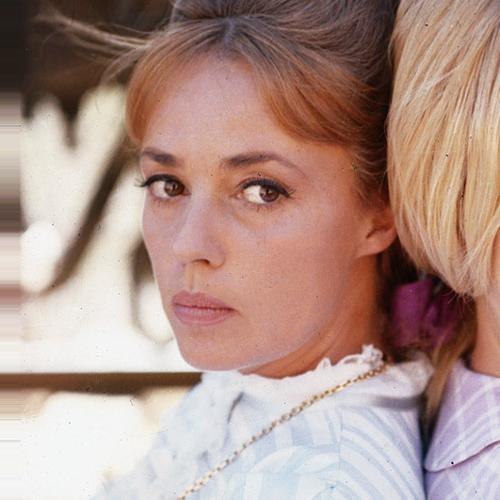

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3395271424_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[ 99.231 262.911 392.832 556.512]]
Face score: 4.094092982957843
Second face score: 3.8147429058659106
Celeb id: 2585



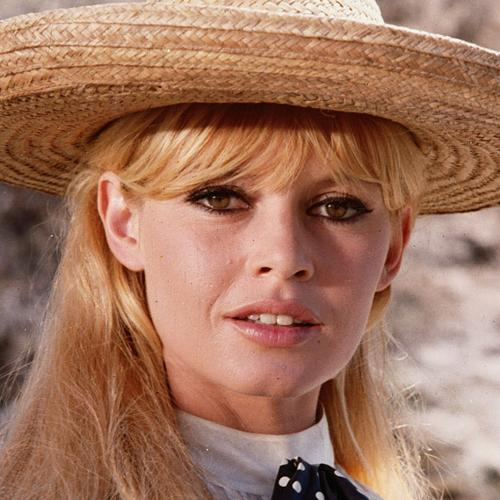

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3428825856_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[246.62203249 246.62203249 561.36921711 561.36921711]]
Face score: 4.2606610575563035
Second face score: nan
Celeb id: 2585



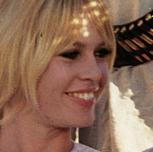

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3445603072_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[264.24952544 245.44763077 347.83505148 329.03315681]]
Face score: 2.8184637263427694
Second face score: 1.430016183817318
Celeb id: 2585



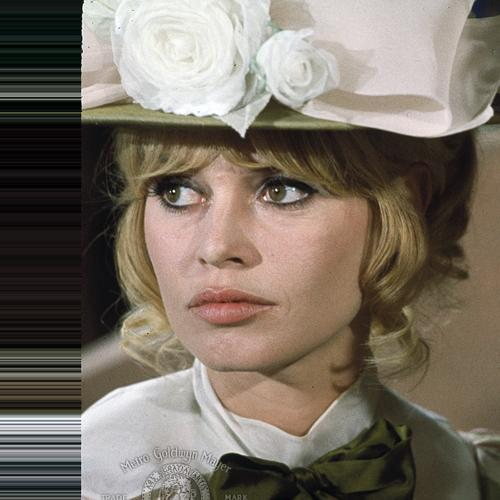

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3462380288_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[ 38.62678935 151.4381574  376.03789349 488.84926154]]
Face score: 2.6423378144029854
Second face score: 2.6411897499082686
Celeb id: 2585



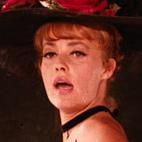

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3479157504_1934-9-28_1965.jpg
Age: 31
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[255.3934265  220.30785043 333.31297266 298.22739659]]
Face score: 2.465981532994811
Second face score: 2.122636884852273
Celeb id: 2585



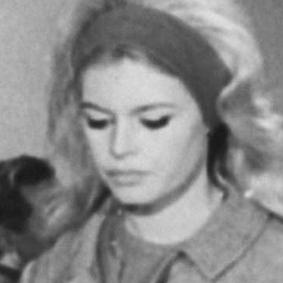

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3515201536_1934-9-28_1962.jpg
Age: 28
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[1090.76405743  247.88710974 1246.75548512  403.87853743]]
Face score: 4.700462238532424
Second face score: 2.836478632900592
Celeb id: 2585



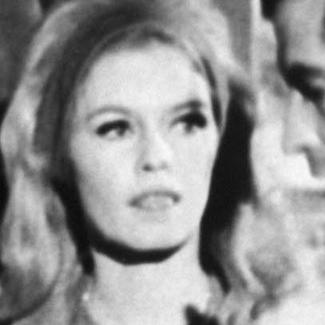

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3531978752_1934-9-28_1962.jpg
Age: 28
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[425.64047143 143.24549048 605.13210205 322.73712109]]
Face score: 3.6575073356535106
Second face score: 1.0973804185601383
Celeb id: 2585



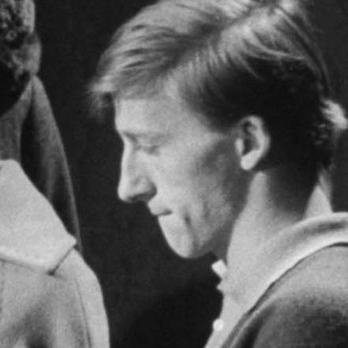

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3548755968_1934-9-28_1962.jpg
Age: 28
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[ 953.27597484  542.51844025 1145.79733334  735.03979874]]
Face score: 3.076207657124516
Second face score: 1.4214109148812826
Celeb id: 2585



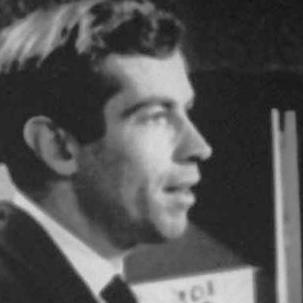

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/03/nm0000003_rm3716528128_1934-9-28_1962.jpg
Age: 28
Gender: 0.0
Name: ['Brigitte Bardot']
Face location: [[1470.02936017  114.96964309 1637.3638248   282.30410772]]
Face score: 3.0742146437463904
Second face score: 1.9640791134940916
Celeb id: 2585



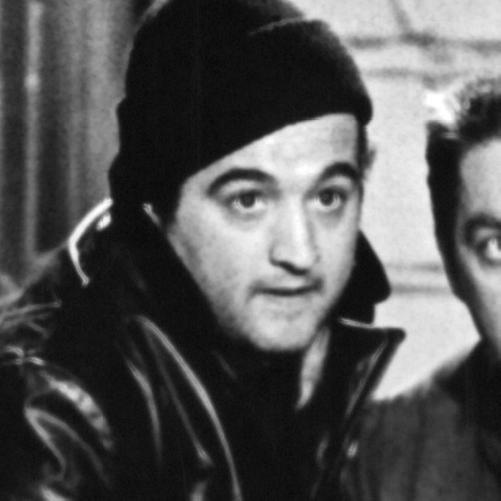

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm1520029184_1949-1-24_1978.jpg
Age: 29
Gender: 1.0
Name: ['John Belushi']
Face location: [[2059.315 1293.995 2416.8   1651.48 ]]
Face score: 3.118805035338234
Second face score: 1.733514715001489
Celeb id: 9474



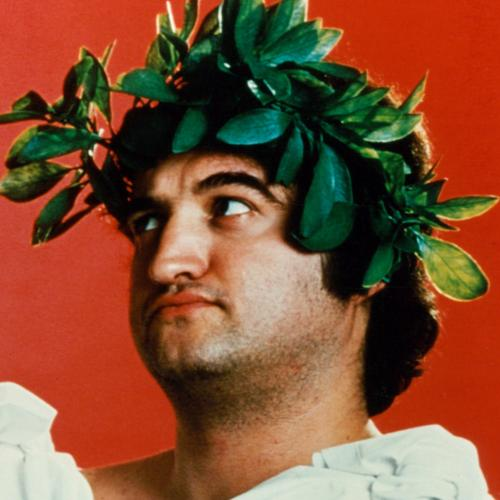

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm1553583616_1949-1-24_1978.jpg
Age: 29
Gender: 1.0
Name: ['John Belushi']
Face location: [[1375.164  689.724 2604.672 1919.232]]
Face score: 2.0000604677333396
Second face score: nan
Celeb id: 9474



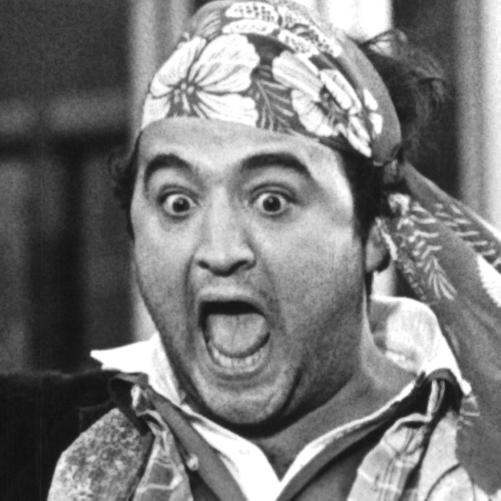

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm1570360832_1949-1-24_1978.jpg
Age: 29
Gender: 1.0
Name: ['John Belushi']
Face location: [[2435.87713392 1131.63281816 2964.19162673 1659.94731097]]
Face score: 3.8344412235337497
Second face score: nan
Celeb id: 9474



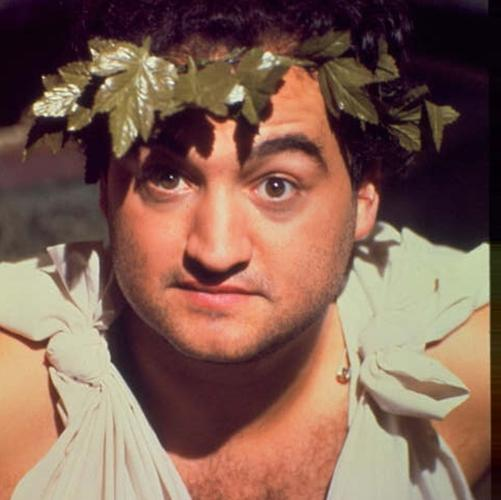

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm1727967232_1949-1-24_1978.jpg
Age: 29
Gender: 1.0
Name: ['John Belushi']
Face location: [[ 405.46940136  486.15368164 1129.57992382 1210.26420409]]
Face score: 4.389420215327456
Second face score: nan
Celeb id: 9474



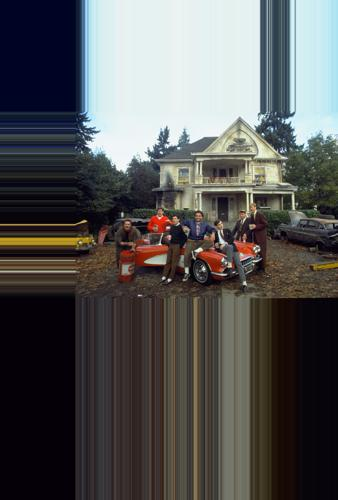

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm1744744448_1949-1-24_1978.jpg
Age: 29
Gender: 1.0
Name: ['John Belushi']
Face location: [[   1    1 1381 2048]]
Face score: -inf
Second face score: nan
Celeb id: 9474



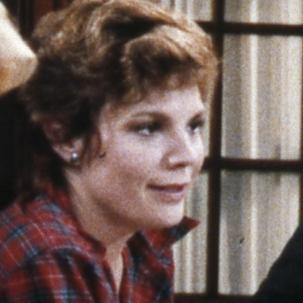

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm3329471232_1949-1-24_1981.jpg
Age: 32
Gender: 1.0
Name: ['John Belushi']
Face location: [[660.75758469 397.27375081 828.09204932 564.60821545]]
Face score: 2.8708528735963017
Second face score: 2.546509837362288
Celeb id: 9474



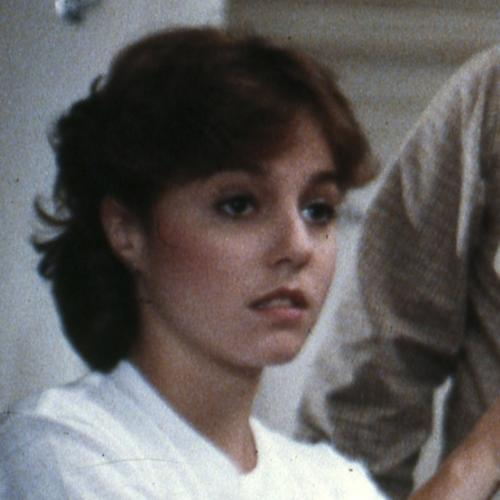

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm3346248448_1949-1-24_1981.jpg
Age: 32
Gender: 1.0
Name: ['John Belushi']
Face location: [[231.424 428.032 524.288 720.896]]
Face score: 3.0838733767304576
Second face score: 2.8773250550102936
Celeb id: 9474



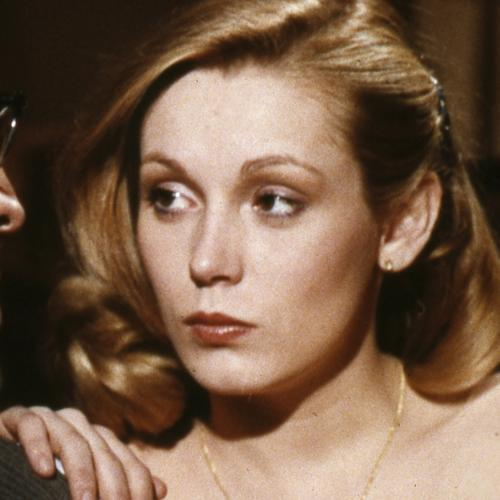

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm4168332032_1949-1-24_1981.jpg
Age: 32
Gender: 1.0
Name: ['John Belushi']
Face location: [[1206.91270031  187.41180005 1621.93325041  602.43235015]]
Face score: 4.5791144448915535
Second face score: 2.1752979779048878
Celeb id: 9474



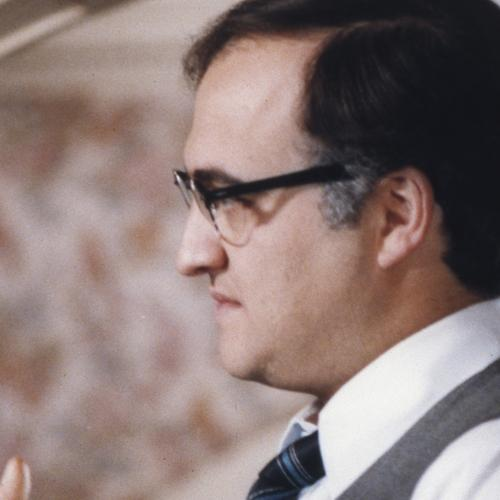

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm4185109248_1949-1-24_1981.jpg
Age: 32
Gender: 1.0
Name: ['John Belushi']
Face location: [[1200.14843604  344.3624103  1711.57205149  855.78602574]]
Face score: 2.9902181331887294
Second face score: 2.273285283989476
Celeb id: 9474



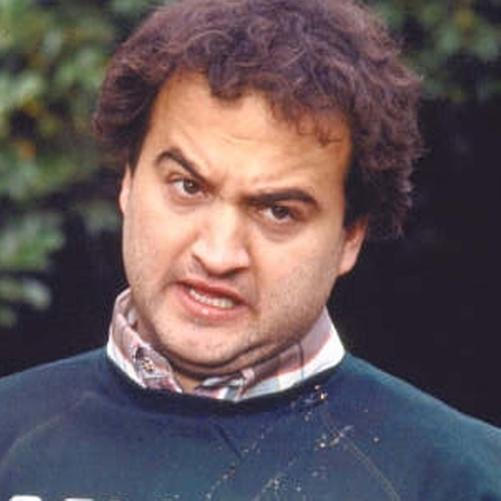

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm419344384_1949-1-24_1978.jpg
Age: 29
Gender: 1.0
Name: ['John Belushi']
Face location: [[548.38500497 200.71600181 993.34000903 645.67100587]]
Face score: 3.380612194364014
Second face score: nan
Celeb id: 9474



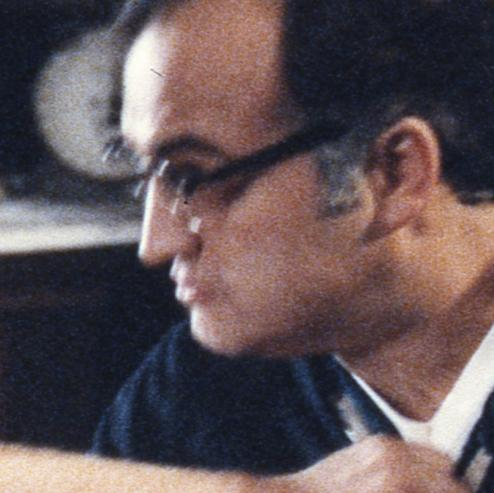

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/04/nm0000004_rm4201886464_1949-1-24_1981.jpg
Age: 32
Gender: 1.0
Name: ['John Belushi']
Face location: [[1286.1402528   338.35787573 1559.2548784   611.47250133]]
Face score: 1.994480282084769
Second face score: 1.7851937691268225
Celeb id: 9474



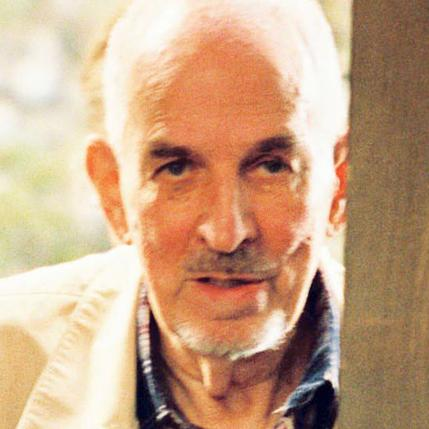

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/05/nm0000005_rm1521844480_1918-7-14_2003.jpg
Age: 85
Gender: 1.0
Name: ['Ingmar Bergman']
Face location: [[ 933.60402833  454.5180709  1171.09900705  692.01304962]]
Face score: 1.7329300364846874
Second face score: nan
Celeb id: 7818



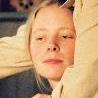

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/05/nm0000005_rm2697042176_1918-7-14_2003.jpg
Age: 85
Gender: 1.0
Name: ['Ingmar Bergman']
Face location: [[326.66031961 163.68215981 380.28237288 217.30421308]]
Face score: 2.2962650530647677
Second face score: 1.8037890855300347
Celeb id: 7818



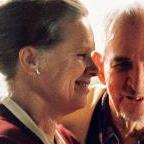

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/05/nm0000005_rm2713819392_1918-7-14_2003.jpg
Age: 85
Gender: 1.0
Name: ['Ingmar Bergman']
Face location: [[142.72783642 249.09871373 221.6059944  327.97687172]]
Face score: 1.96810804045219
Second face score: nan
Celeb id: 7818



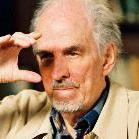

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/05/nm0000005_rm2898368768_1918-7-14_2003.jpg
Age: 85
Gender: 1.0
Name: ['Ingmar Bergman']
Face location: [[222.65340827 111.67870413 298.77804959 187.80334546]]
Face score: 2.421371161058074
Second face score: nan
Celeb id: 7818



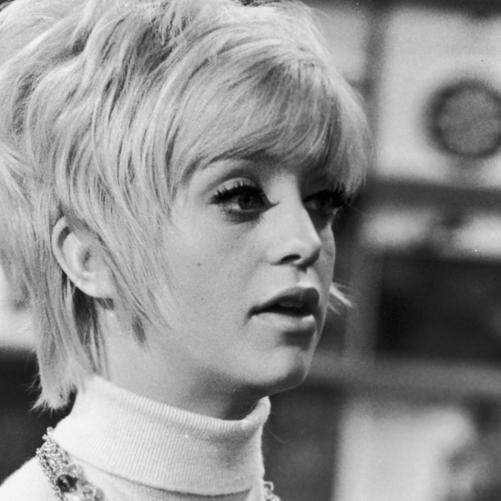

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm1640745984_1915-8-29_1969.jpg
Age: 54
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[ 939.86863188  599.7804021  1700.44114887 1360.3529191 ]]
Face score: 3.6110526195352763
Second face score: 3.2786155688352485
Celeb id: 7820



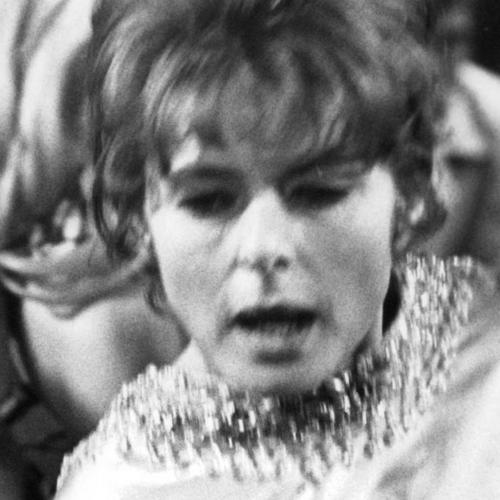

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm1691077632_1915-8-29_1969.jpg
Age: 54
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[2643.0215059  1826.78446836 3202.16068574 2385.9236482 ]]
Face score: 2.2292231660626336
Second face score: 1.6267350437874635
Celeb id: 7820



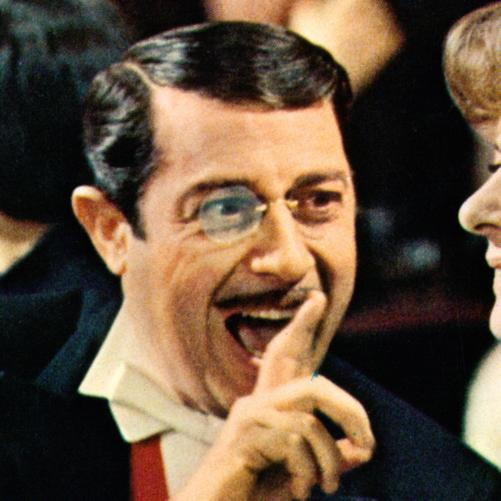

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm1707854848_1915-8-29_1969.jpg
Age: 54
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[1266.72168173  635.50734086 1972.5448152  1341.33047434]]
Face score: 3.9948460869518443
Second face score: 3.1186507621452737
Celeb id: 7820



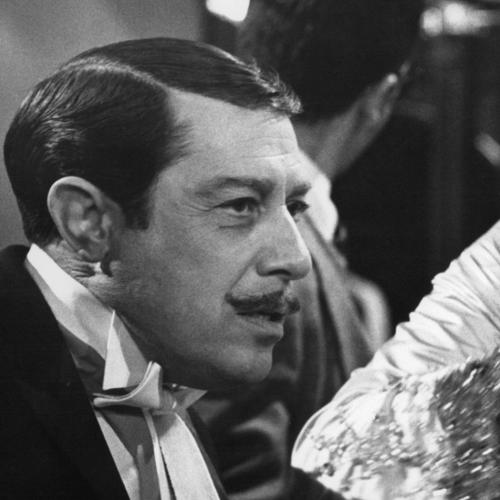

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm1724632064_1915-8-29_1969.jpg
Age: 54
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[1430.817 1430.817 2279.808 2279.808]]
Face score: 3.070690900187579
Second face score: 2.1681982378580034
Celeb id: 7820



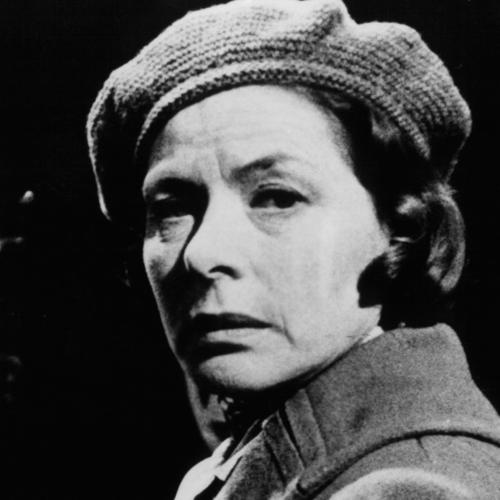

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm221957120_1915-8-29_1974.jpg
Age: 59
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[3173.14469259  401.04083657 4059.15207489 1287.04821887]]
Face score: 4.0964305784174595
Second face score: nan
Celeb id: 7820



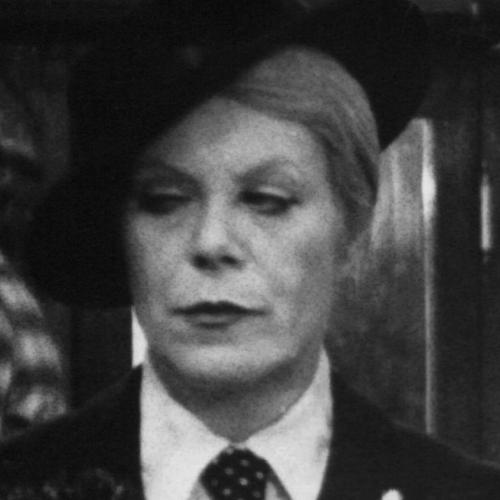

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm305843200_1915-8-29_1974.jpg
Age: 59
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[1020.12114152  743.27564838 1430.36838123 1153.52288809]]
Face score: 4.521520133398809
Second face score: 3.694407219378071
Celeb id: 7820



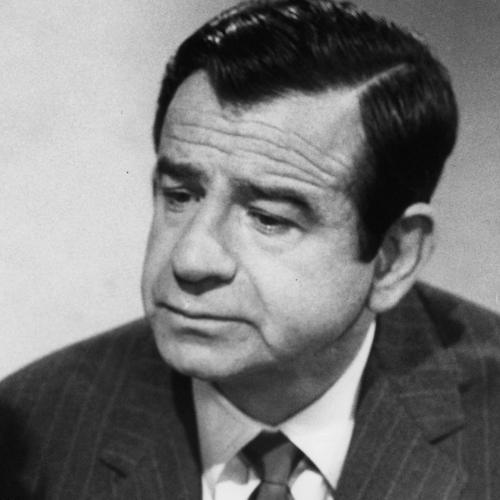

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm416009216_1915-8-29_1969.jpg
Age: 54
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[2753.885  975.229 3476.464 1697.808]]
Face score: 3.1513739335970445
Second face score: 2.595128193747086
Celeb id: 7820



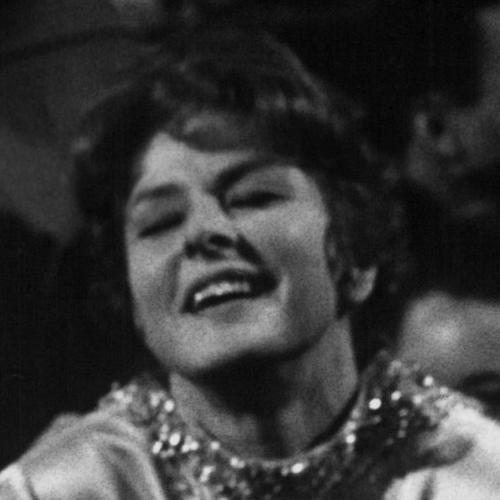

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm432786432_1915-8-29_1969.jpg
Age: 54
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[2619.981  956.501 3041.792 1378.312]]
Face score: 2.2220934050591614
Second face score: 1.0303182126311037
Celeb id: 7820



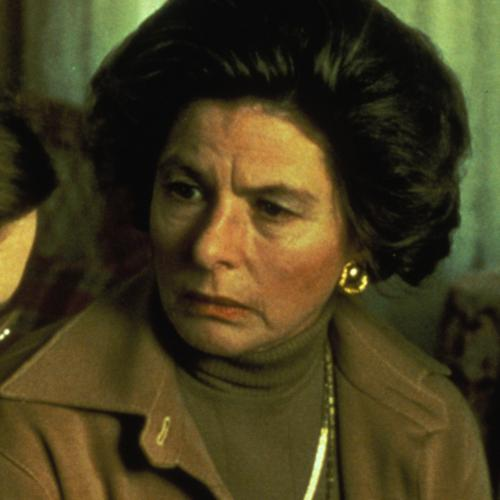

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/06/nm0000006_rm469283328_1915-8-29_1978.jpg
Age: 63
Gender: 0.0
Name: ['Ingrid Bergman']
Face location: [[1200.14843604  287.31000858 1711.57205149  798.73362403]]
Face score: 3.4723093017328504
Second face score: 1.327453391087569
Celeb id: 7820



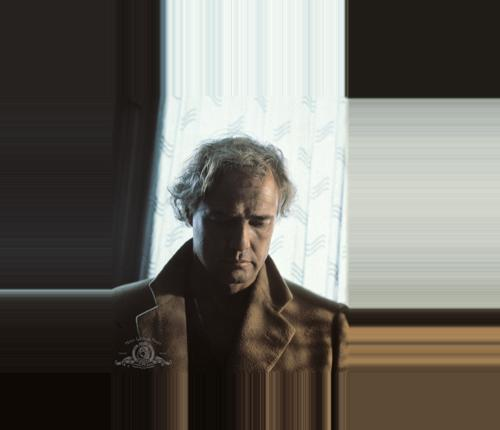

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/08/nm0000008_rm1221625088_1924-4-3_1972.jpg
Age: 48
Gender: 1.0
Name: ['Marlon Brando']
Face location: [[   1    1 1023  878]]
Face score: -inf
Second face score: nan
Celeb id: 12843



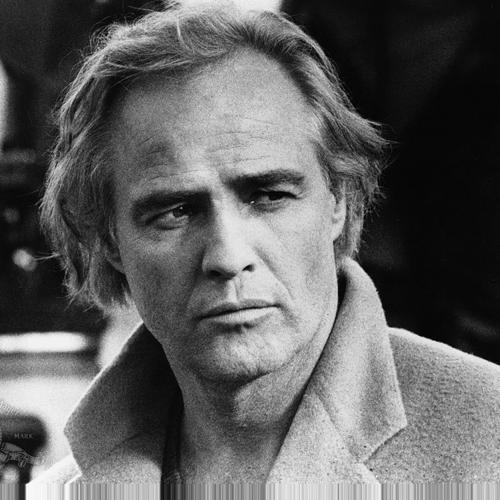

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/08/nm0000008_rm1238402304_1924-4-3_1972.jpg
Age: 48
Gender: 1.0
Name: ['Marlon Brando']
Face location: [[325.09286624 232.50147589 740.73112285 648.13973249]]
Face score: 4.157366763416131
Second face score: nan
Celeb id: 12843



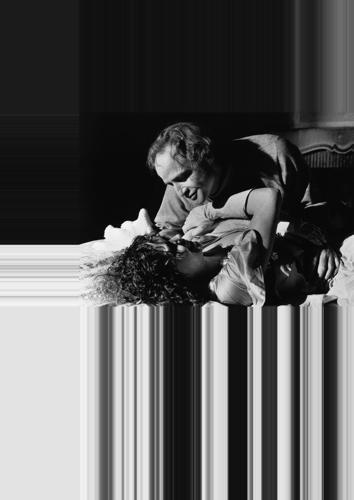

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/08/nm0000008_rm1271956736_1924-4-3_1972.jpg
Age: 48
Gender: 1.0
Name: ['Marlon Brando']
Face location: [[   1    1  722 1023]]
Face score: -inf
Second face score: nan
Celeb id: 12843



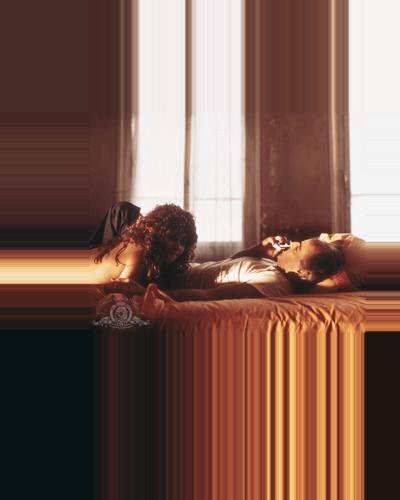

Path: /home/ubuntu/coding/cnn/datasets/imdb_crop/08/nm0000008_rm1288733952_1924-4-3_1972.jpg
Age: 48
Gender: 1.0
Name: ['Marlon Brando']
Face location: [[   1    1  818 1023]]
Face score: -inf
Second face score: nan
Celeb id: 12843



In [18]:
for i in range(100):
    display(Image(filename=raw_path[i]))
    print("Path: " + str(raw_path[i]))
    print("Age: " + str(raw_age[i]))
    print("Gender: " + str(raw_gender[i]))
    print("Name: " + str(raw_name[i]))
    print("Face location: " + str(raw_face_location[i]))
    print("Face score: " + str(raw_face_score[i]))
    print("Second face score: " + str(raw_second_face_score[i]))
    print("Celeb id: " + str(raw_celeb_id[i])+"\n")
    
    